Libraries importing

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

2024-09-15 23:14:25.687158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset loading and preprocessing

In [2]:
# Load the dataset
df = pd.read_csv('IGI.csv')

# Feature engineering (example features: glucose levels, time of day, etc.)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

# Features (X) and target (y)
X = df[['Glucose_old', 'Glucose_new', 'sin_hour', 'cos_hour']].values
y = df['Insulin'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, df.index, test_size=0.2, random_state=42)


Storage the results to be used for all algorithms

In [3]:
# Initialize result storage
results = {'Algorithm': [], 'RMSE': [], 'MAE': []}

Linear Regression

In [4]:
# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)

# Store results
results['Algorithm'].append('Linear Regression')
results['RMSE'].append(lr_rmse)
results['MAE'].append(lr_mae)

Random Forest Regressor

In [5]:
# 2. Random Forest Regressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)

# Store results
results['Algorithm'].append('Random Forest')
results['RMSE'].append(rf_rmse)
results['MAE'].append(rf_mae)


PCA (Standalone for Visualization)

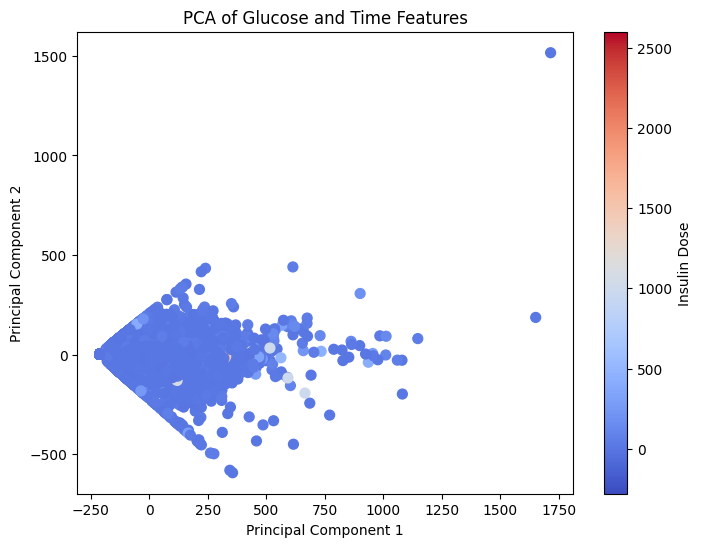

In [6]:
# 3. PCA (Standalone for Visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', s=50)
plt.title('PCA of Glucose and Time Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Insulin Dose')
plt.show()


PCA + Linear Regression

In [7]:
# 4. PCA + Linear Regression
pca = PCA(n_components=2)  # Reduce dimensionality to 2 components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Linear Regression on the PCA-reduced data
pca_lr = LinearRegression()
pca_lr.fit(X_train_pca, y_train)
pca_lr_pred = pca_lr.predict(X_test_pca)

# Evaluate Linear Regression after PCA
pca_lr_rmse = np.sqrt(mean_squared_error(y_test, pca_lr_pred))
pca_lr_mae = mean_absolute_error(y_test, pca_lr_pred)

# Store results
results['Algorithm'].append('PCA + Linear Regression')
results['RMSE'].append(pca_lr_rmse)
results['MAE'].append(pca_lr_mae)


Deep Neural Network (DNN)

In [8]:
# 5. Build the DNN model
def build_dnn_model(input_shape):
    model = Sequential()
    model.add(Dense(64, input_dim=input_shape, activation='relu'))  # First hidden layer
    model.add(Dense(64, activation='relu'))  # Second hidden layer
    model.add(Dense(1, activation='linear'))  # Output layer (for regression)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Train the DNN
dnn_model = build_dnn_model(X_train.shape[1])
dnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions using DNN
dnn_pred = dnn_model.predict(X_test).flatten()

# Evaluate DNN performance
dnn_rmse = np.sqrt(mean_squared_error(y_test, dnn_pred))
dnn_mae = mean_absolute_error(y_test, dnn_pred)

# Store results
results['Algorithm'].append('Deep Neural Network')
results['RMSE'].append(dnn_rmse)
results['MAE'].append(dnn_mae)


Train on 78194 samples, validate on 19549 samples
Epoch 1/50
 1088/78194 [..............................] - ETA: 7s - loss: 874.9460 - mae: 21.3906   

2024-09-15 23:14:45.579663: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-09-15 23:14:45.587570: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2024-09-15 23:14:45.605354: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/learning_rate/Assign' id:225 op device:{requested: '', assigned: ''} def:{{{node training/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/learning_rate, training/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


77920/78194 [============================>.] - ETA: 0s - loss: 535.9617 - mae: 8.7038

/home/orion/anaconda3/envs/Reinforcement-Learning/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-15 23:14:51.153262: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:117 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_2_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


78194/78194 [==============================] - 6s 82us/sample - loss: 534.5153 - mae: 8.6946 - val_loss: 668.5328 - val_mae: 6.9625
Epoch 2/50
78194/78194 [==============================] - 4s 49us/sample - loss: 516.6993 - mae: 8.1737 - val_loss: 653.5907 - val_mae: 7.6315
Epoch 3/50
78194/78194 [==============================] - 3s 44us/sample - loss: 513.7601 - mae: 8.1146 - val_loss: 652.5474 - val_mae: 7.9277
Epoch 4/50
78194/78194 [==============================] - 3s 45us/sample - loss: 512.6454 - mae: 8.0784 - val_loss: 653.3744 - val_mae: 8.3922
Epoch 5/50
78194/78194 [==============================] - 4s 46us/sample - loss: 512.2426 - mae: 8.0861 - val_loss: 652.6958 - val_mae: 7.8133
Epoch 6/50
78194/78194 [==============================] - 4s 45us/sample - loss: 512.3041 - mae: 8.0568 - val_loss: 659.2674 - val_mae: 9.2690
Epoch 7/50
78194/78194 [==============================] - 3s 35us/sample - loss: 511.9071 - mae: 8.1081 - val_loss: 653.6687 - val_mae: 7.5631
Epoch 8/50

/home/orion/anaconda3/envs/Reinforcement-Learning/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-15 23:18:00.572059: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_2/BiasAdd' id:73 op device:{requested: '', assigned: ''} def:{{{node dense_2/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_2/MatMul, dense_2/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Display Results for All Algorithms

In [9]:
# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Save the results to a text file
results_df.to_csv('results.txt', sep='\t', index=False)

print("Results have been saved to 'results.txt'.")


                 Algorithm       RMSE       MAE
0        Linear Regression  22.963050  8.167320
1            Random Forest  24.266935  9.449843
2  PCA + Linear Regression  22.965791  8.165871
3      Deep Neural Network  22.948758  8.027974
Results have been saved to 'results.txt'.


Plot Actual vs Predicted Insulin Dosages

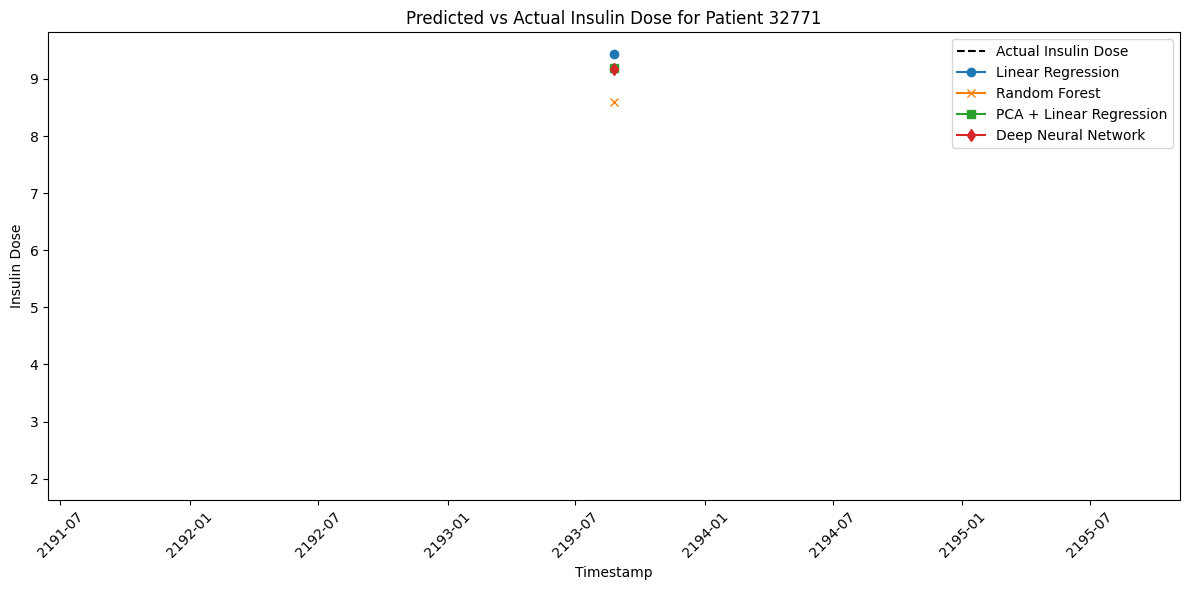

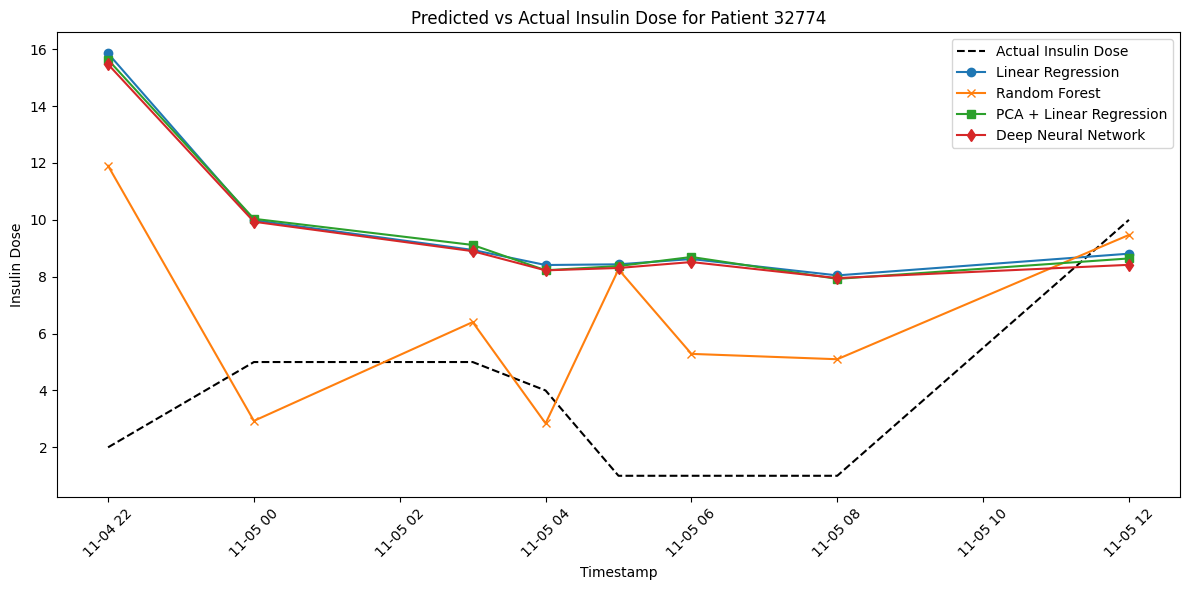

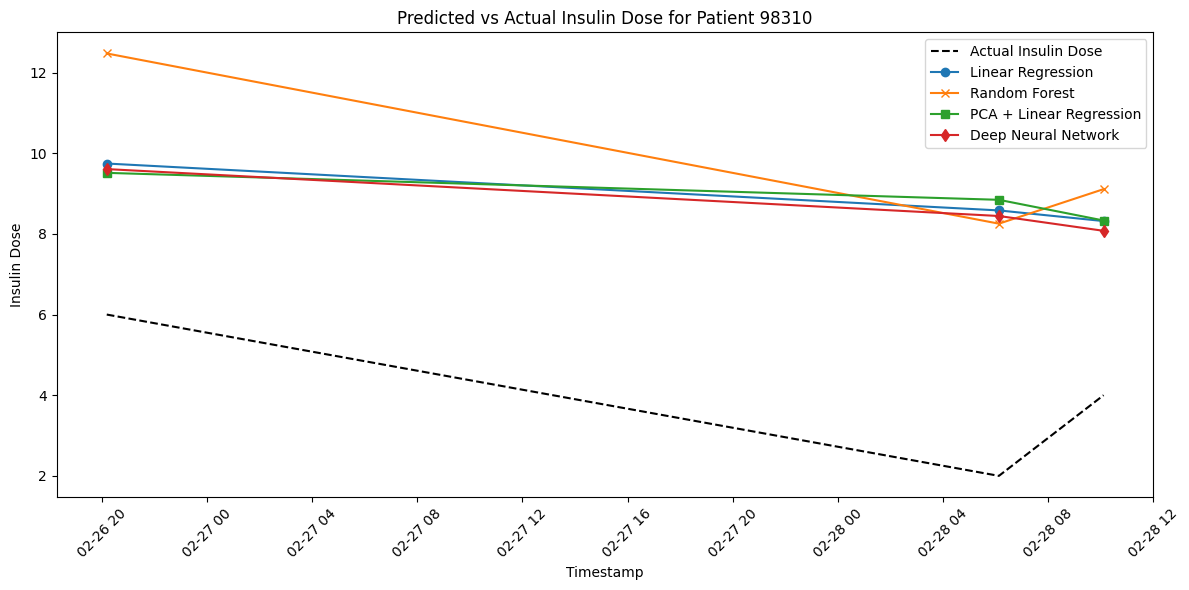

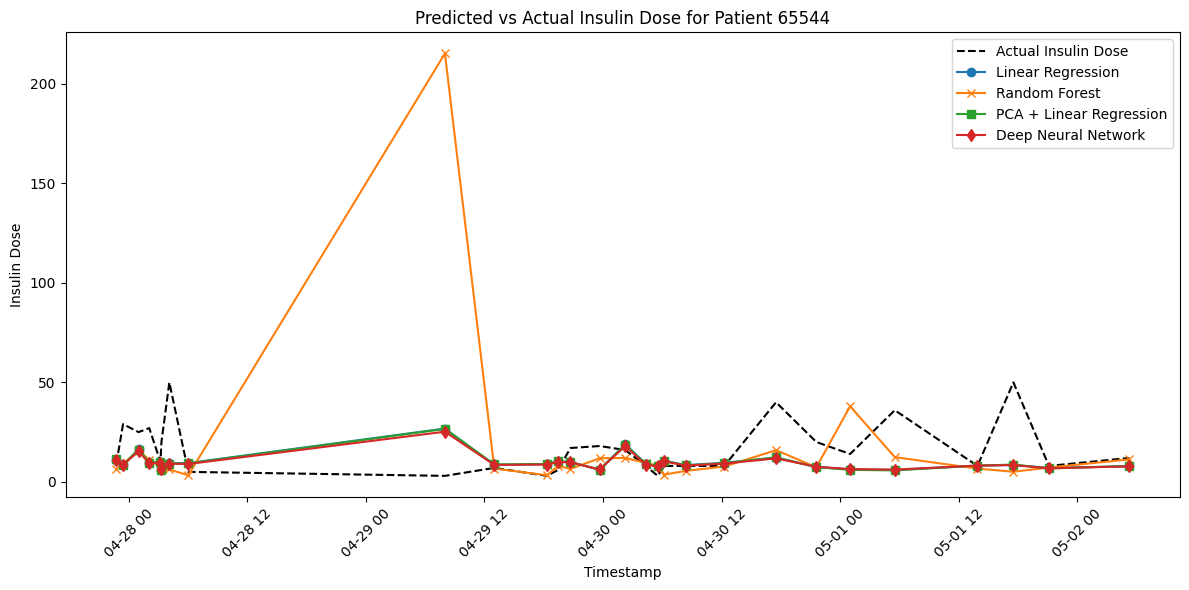

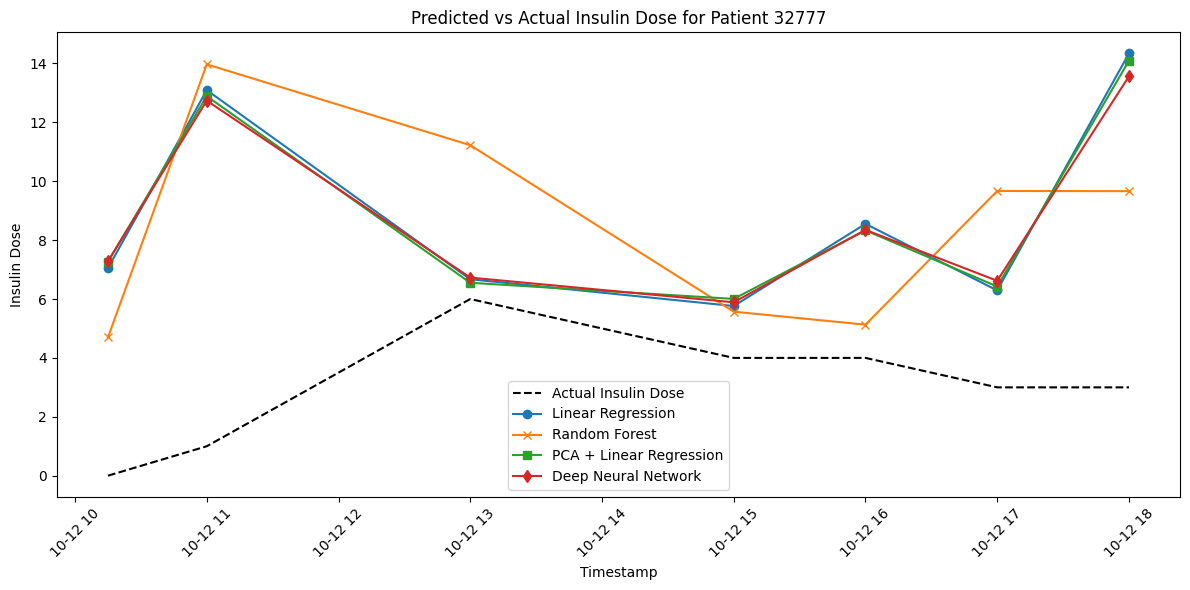

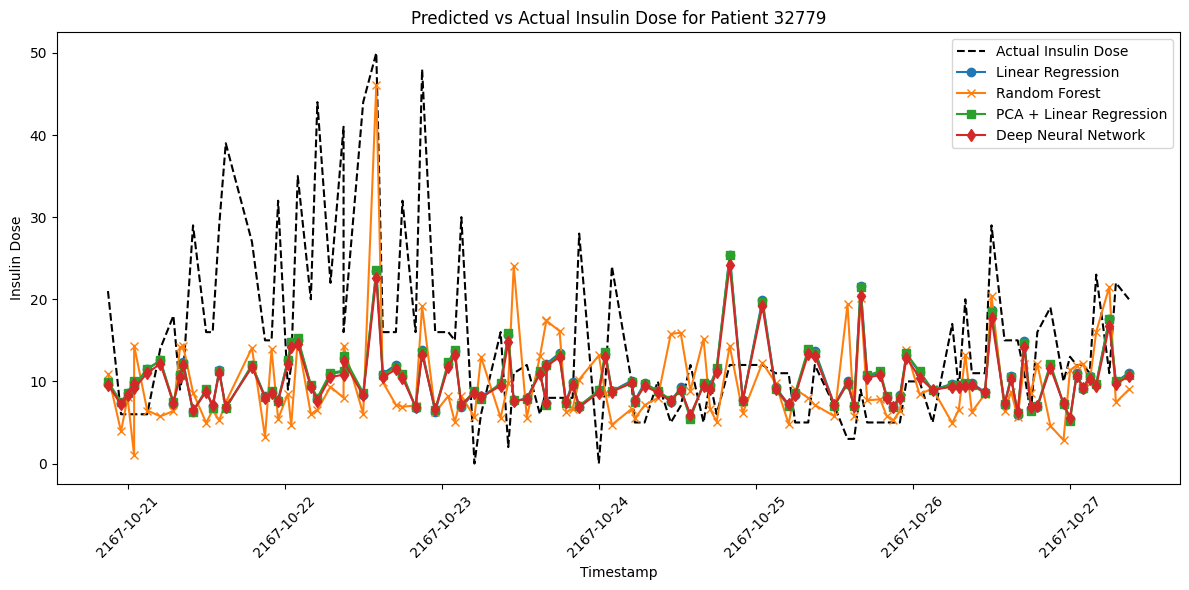

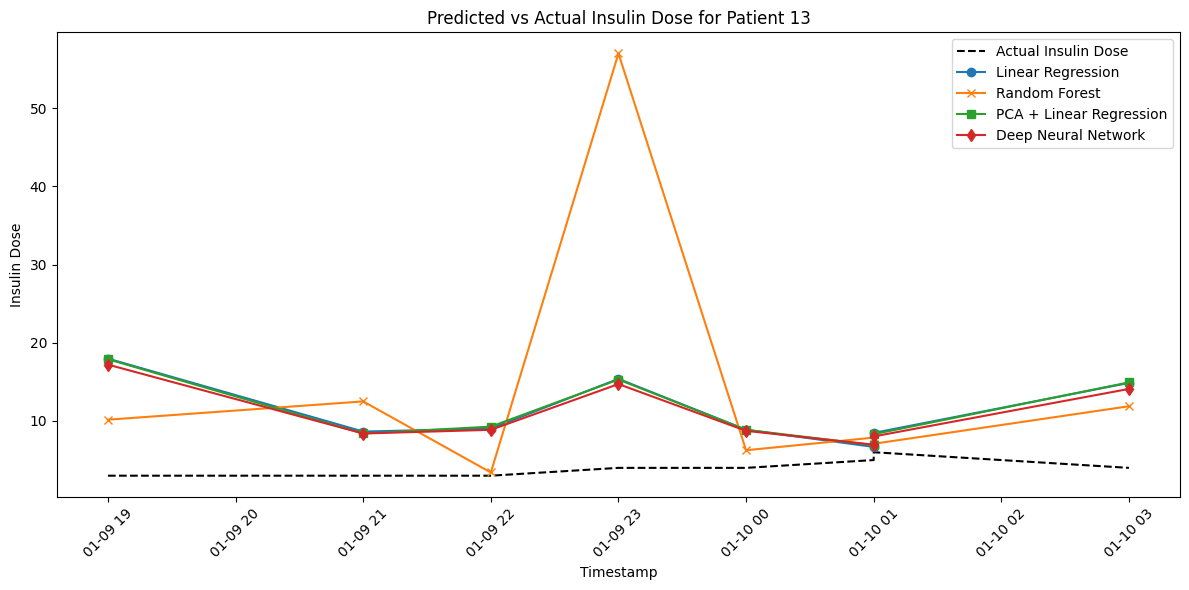

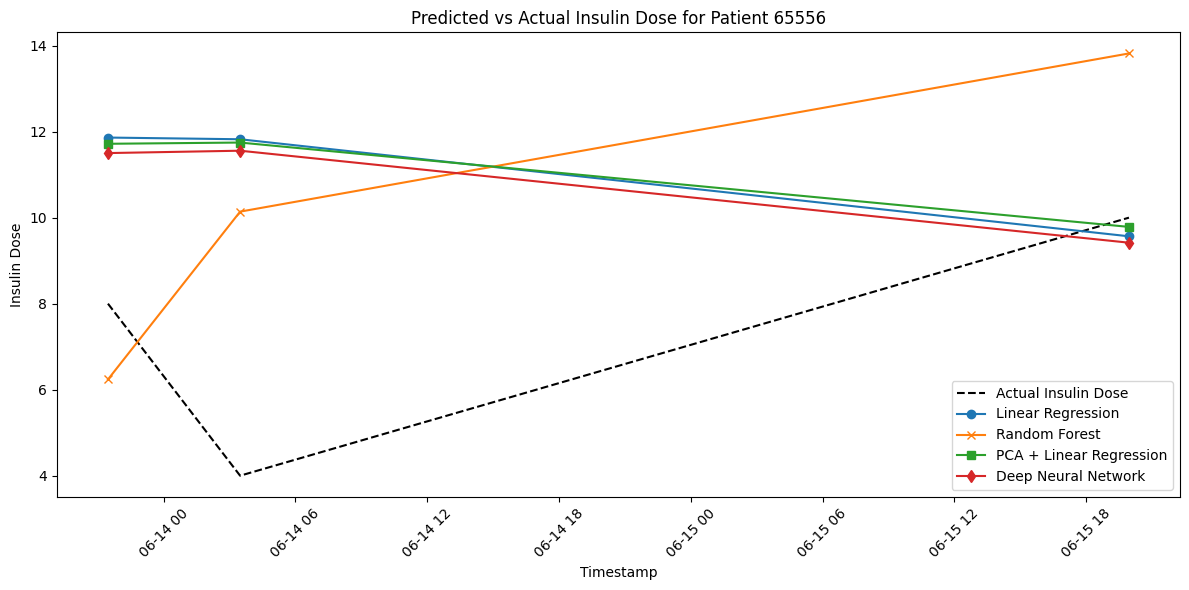

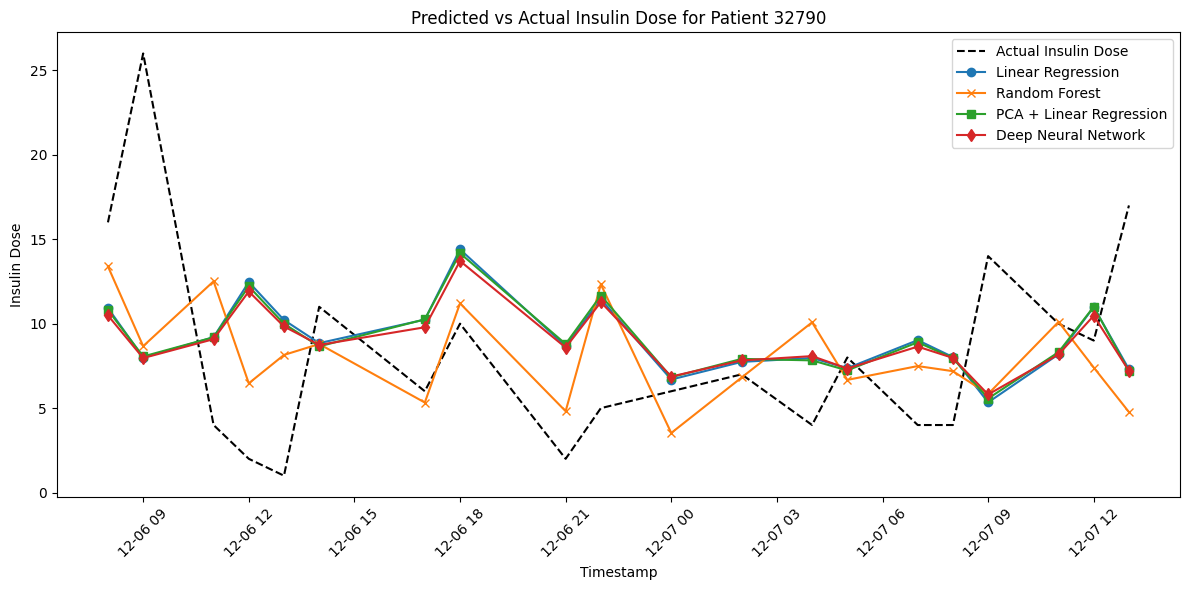

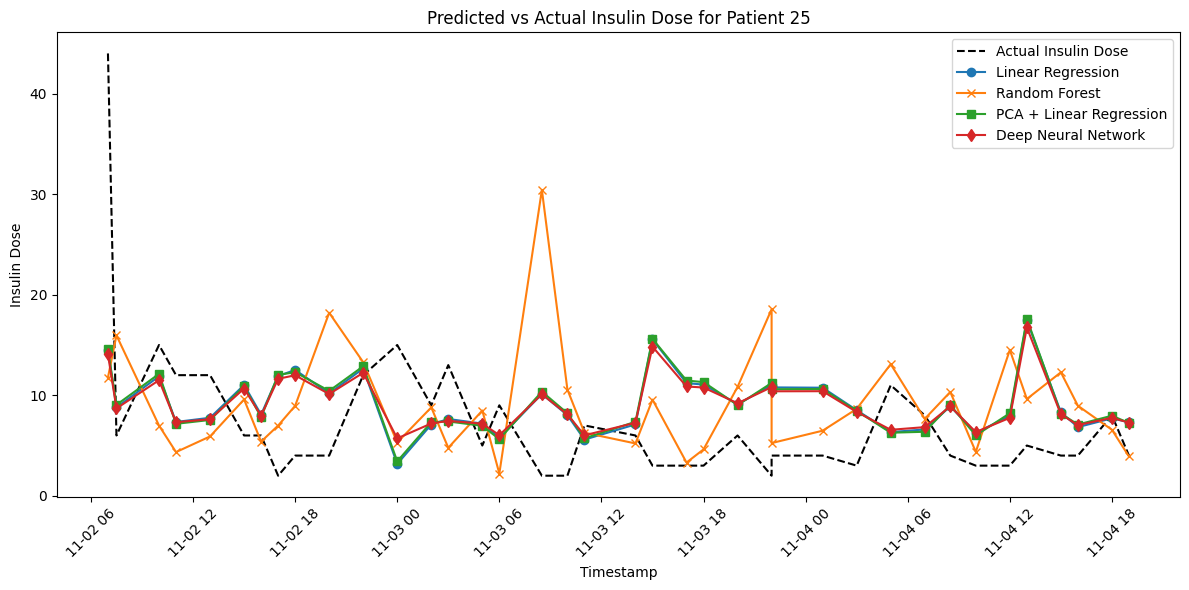

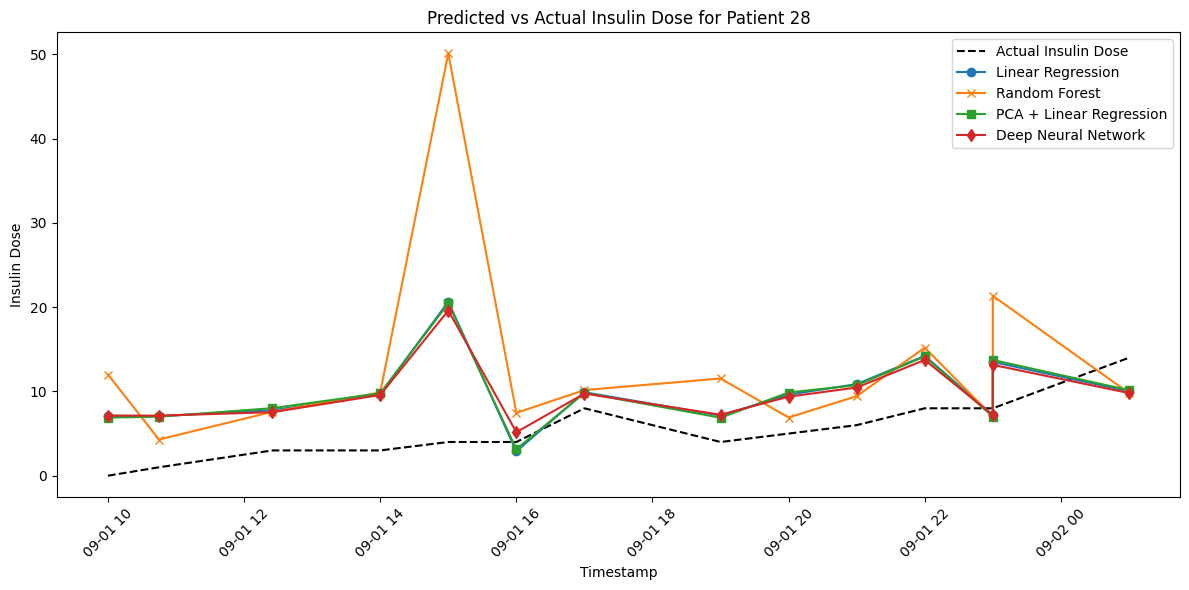

Plots saved successfully.


In [10]:
import matplotlib.pyplot as plt

# Loop through each of the first 11 patients to generate and save time series plots
for patient_id in df['id'].unique()[:11]:
    # Filter the data for the current patient
    patient_data = df[df['id'] == patient_id]

    # Extract indices for this patient's data
    patient_index = patient_data.index
    
    # Predicted values for each model for this patient
    lr_pred_patient = lr_pred[patient_index]
    rf_pred_patient = rf_pred[patient_index]
    pca_lr_pred_patient = pca_lr_pred[patient_index]
    dnn_pred_patient = dnn_pred[patient_index]
    actual_dose = patient_data['Insulin']
    timestamps = patient_data['timestamp']
    
    # --- Plot 1: Predicted vs Actual Insulin Dose (Time Series) ---
    plt.figure(figsize=(12, 6))
    
    # Plot actual insulin dose
    plt.plot(timestamps, actual_dose, label='Actual Insulin Dose', color='black', linestyle='--')
    
    # Plot predicted values from each model
    plt.plot(timestamps, lr_pred_patient, label='Linear Regression', marker='o')
    plt.plot(timestamps, rf_pred_patient, label='Random Forest', marker='x')
    plt.plot(timestamps, pca_lr_pred_patient, label='PCA + Linear Regression', marker='s')
    plt.plot(timestamps, dnn_pred_patient, label='Deep Neural Network', marker='d')
    
    # Customize the plot
    plt.xlabel('Timestamp')
    plt.ylabel('Insulin Dose')
    plt.title(f'Predicted vs Actual Insulin Dose for Patient {patient_id}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot with the patient's ID in the filename
    plt.savefig(f'patient_{patient_id}_insulin_dose_plot.png')
    
    # Show the plot
    plt.show()

print("Plots saved successfully.")



Scatter Plot Between Insulin Dosage and Glucose Levels

/home/orion/anaconda3/envs/Reinforcement-Learning/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


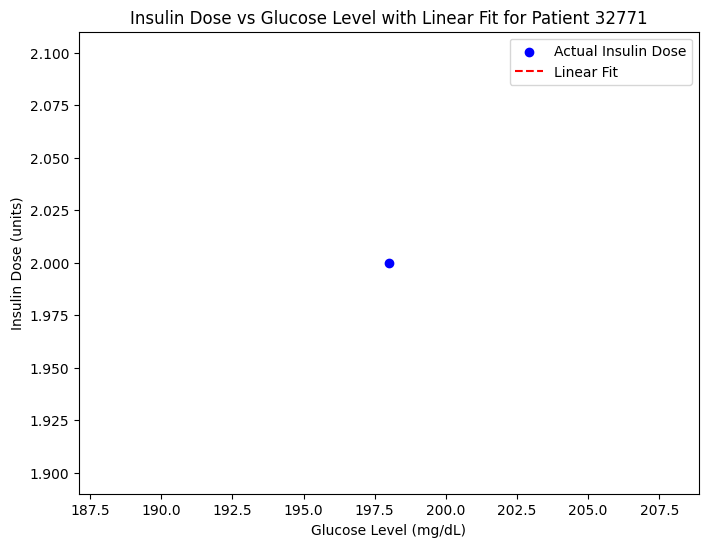

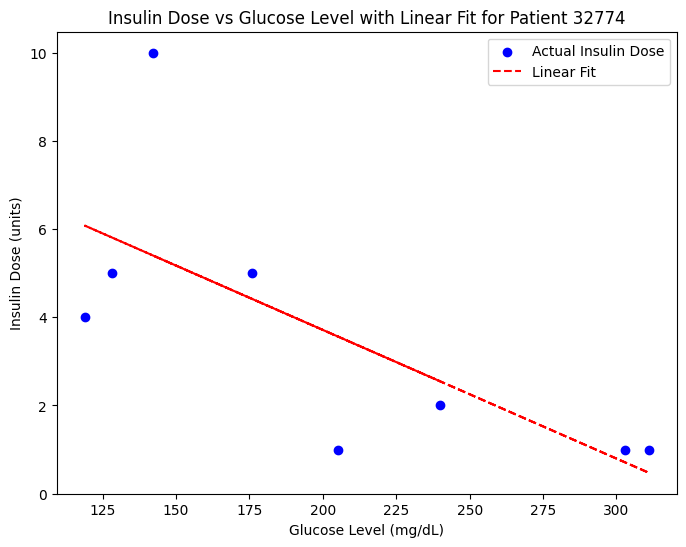

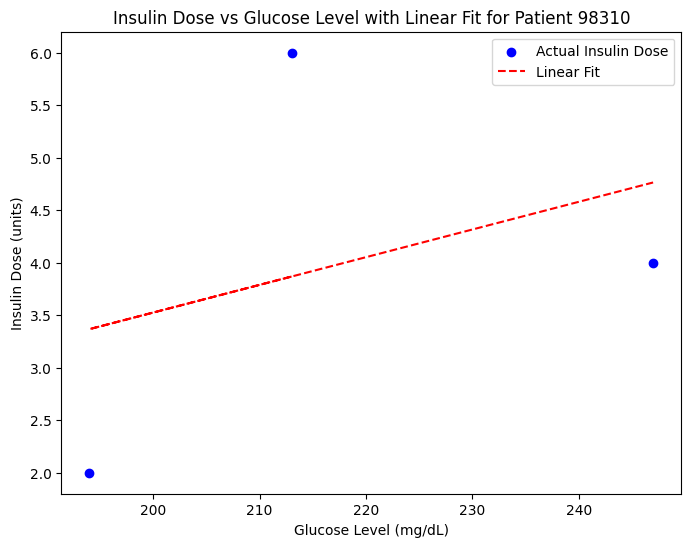

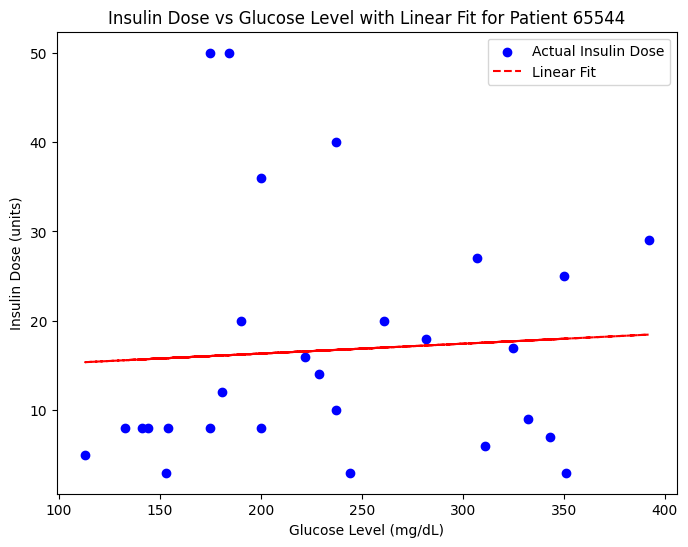

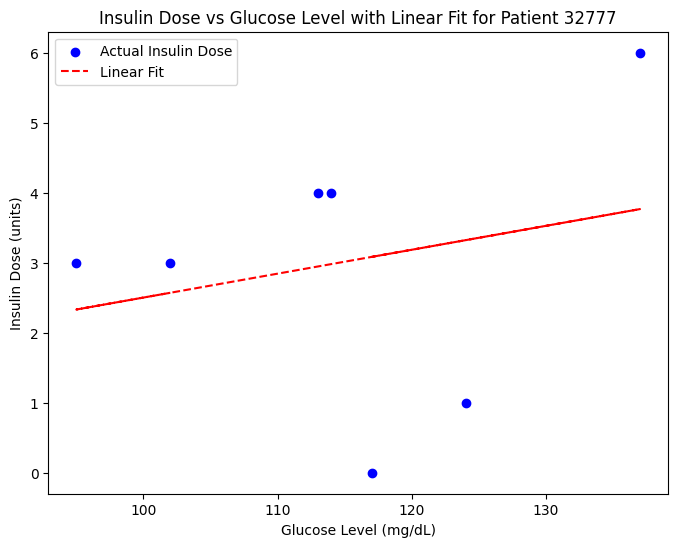

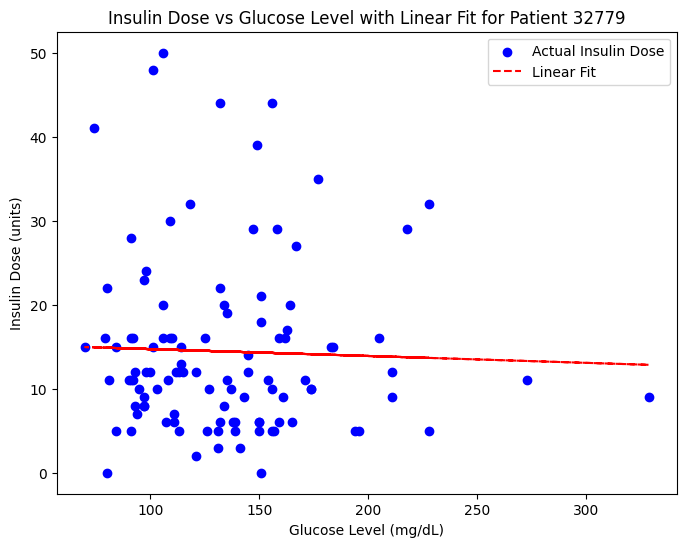

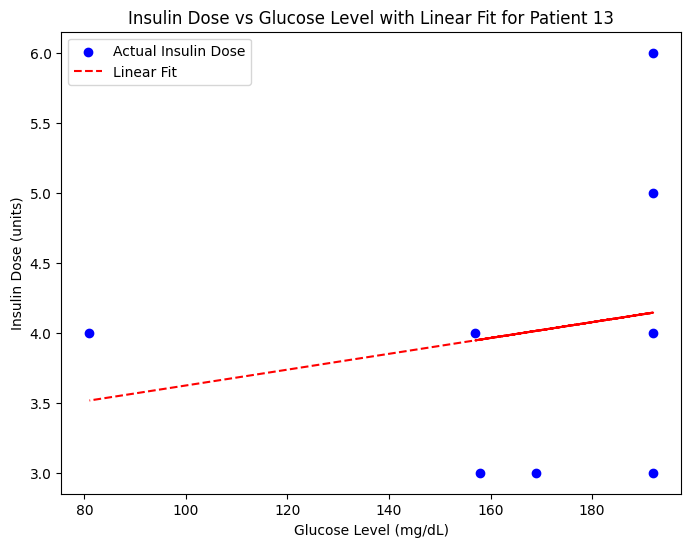

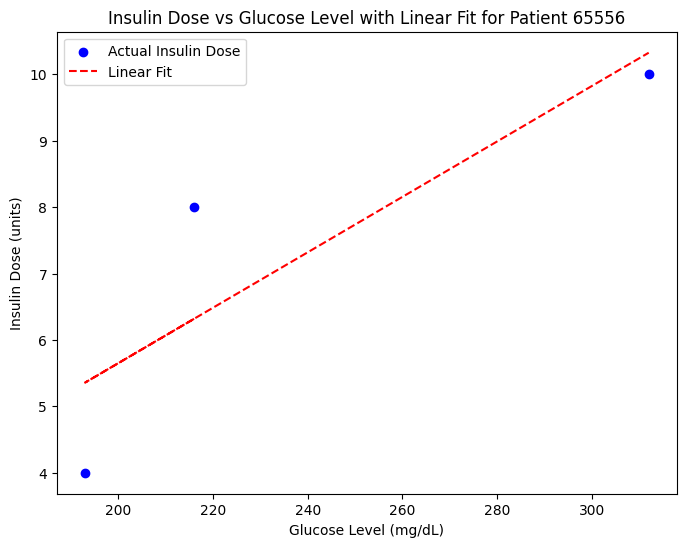

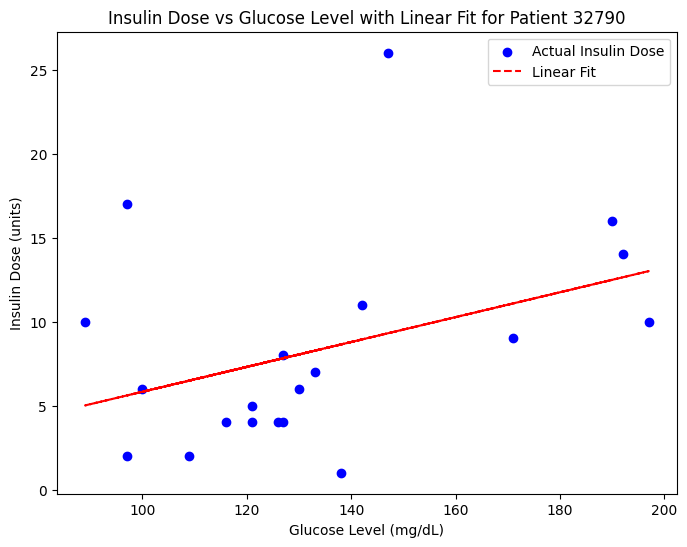

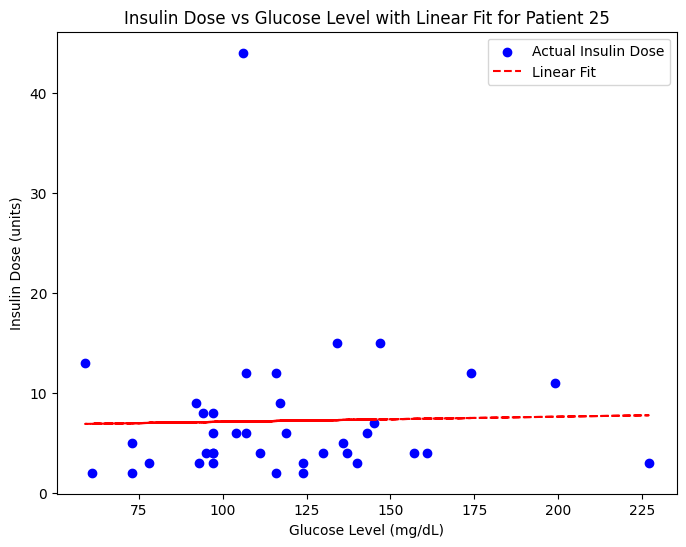

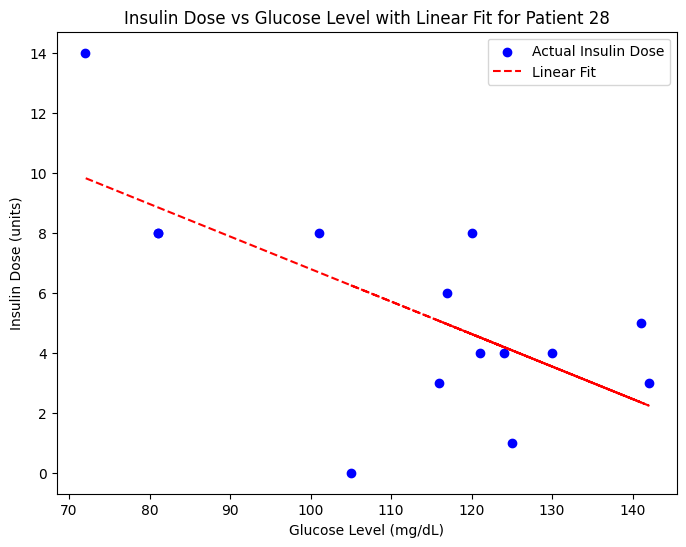

Linear fit plots saved successfully.


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Loop through each of the first 11 patients to generate and save linear fit plots
for patient_id in df['id'].unique()[:11]:
    # Filter the data for the current patient
    patient_data = df[df['id'] == patient_id]
    
    # Extract glucose levels and insulin dose for this patient
    glucose_old = patient_data['Glucose_old']
    actual_dose = patient_data['Insulin']
    
    # Compute a linear fit (slope and intercept)
    slope, intercept = np.polyfit(glucose_old, actual_dose, 1)  # Degree 1 for linear fit
    linear_fit = slope * glucose_old + intercept  # Compute the linear fit values
    
    # --- Plot 3: Insulin Dose vs Glucose Level with Linear Fit ---
    plt.figure(figsize=(8, 6))
    
    # Scatter plot for actual insulin dose vs glucose levels
    plt.scatter(glucose_old, actual_dose, color='blue', label='Actual Insulin Dose')
    
    # Plot the linear fit with a dashed red line
    plt.plot(glucose_old, linear_fit, color='red', linestyle='--', label='Linear Fit')
    
    # Customize the plot
    plt.xlabel('Glucose Level (mg/dL)')
    plt.ylabel('Insulin Dose (units)')
    plt.title(f'Insulin Dose vs Glucose Level with Linear Fit for Patient {patient_id}')
    plt.legend()
    
    # Save the plot with the patient's ID in the filename
    plt.savefig(f'patient_{patient_id}_linear_fit_plot.png')
    
    # Show the plot
    plt.show()

print("Linear fit plots saved successfully.")

